In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mplPath

import seaborn as sns

from scipy import ndimage, misc

sns.set(color_codes=True)

%matplotlib inline


In [2]:
from image_utils import harrisResponse, response2points, nonMaximalSuppression

from scipy.spatial import Delaunay

In [3]:
#art = misc.imread("pictures/orlok.jpg")
art = misc.imread("pictures/marceline.jpg")

In [4]:
art.shape

(1227, 900, 3)

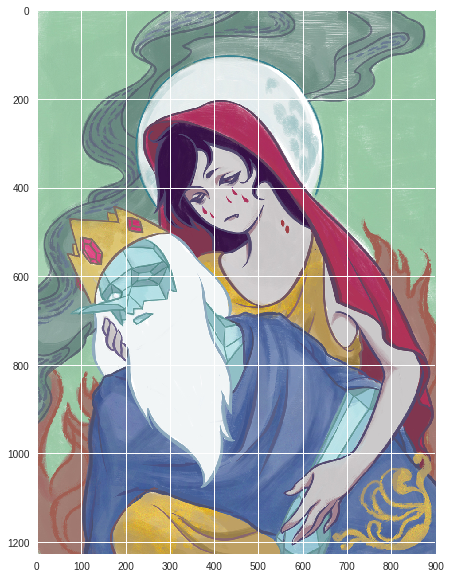

In [5]:
fig = plt.figure(figsize=(10,10))
axs = fig.add_subplot(111)

axs.imshow(art)

plt.show()

In [6]:
hsv_art = mpl.colors.rgb_to_hsv(art)
rgb_art = mpl.colors.hsv_to_rgb(hsv_art).astype(int)

#### Blur an image

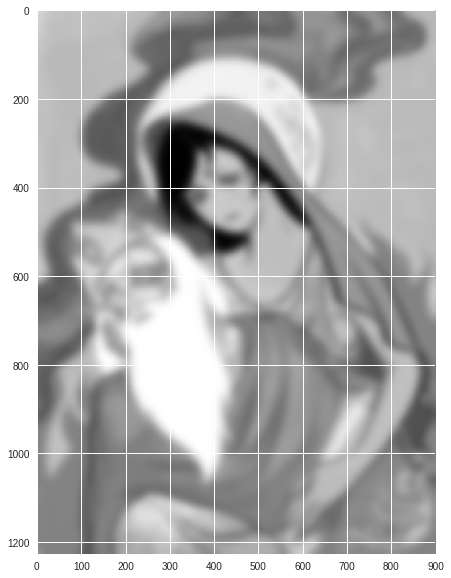

In [7]:
fig = plt.figure(figsize=(10,10))
axs = fig.add_subplot(111)

#axs.imshow(hsv_art[:,:,1])
im_smooth = np.zeros(hsv_art[:,:,0].shape)
ndimage.filters.gaussian_filter(hsv_art[:,:,2], (10,10), (0,0), im_smooth)
#axs.imshow(hsv_art[:,:,1] - im_smooth)

axs.imshow(im_smooth, cmap='gray')
plt.show()

# fig = plt.figure(figsize=(10,10))
# axs = fig.add_subplot(111)

# sharp_im = hsv_art[:,:,2] - im_smooth
# sharp_im = sharp_im + np.min(sharp_im)
# axs.imshow(sharp_im + np.min(sharp_im), cmap = 'gray')

# plt.show()

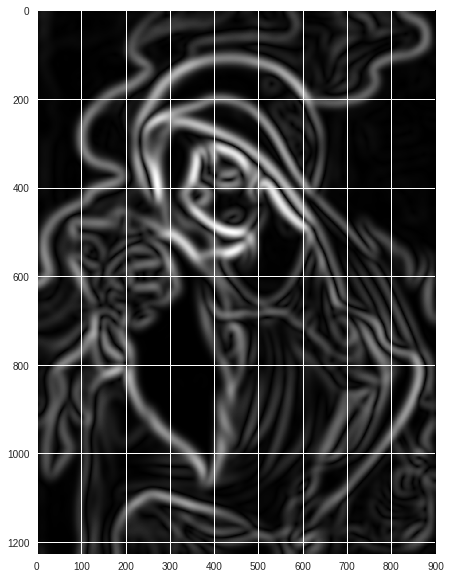

In [8]:
im_x = np.zeros(im_smooth.shape)
sigma = 2
ndimage.filters.gaussian_filter(im_smooth, (sigma,sigma), (0,1), im_x)

im_y = np.zeros(im_smooth.shape)
ndimage.filters.gaussian_filter(im_smooth, (sigma,sigma), (1,0), im_y)
plt.show()

fig = plt.figure(figsize=(10,10))
axs = fig.add_subplot(111)
smooth_grad_mag = np.sqrt(im_y**2 + im_x**2)
axs.imshow(smooth_grad_mag, cmap = 'gray')

plt.show()


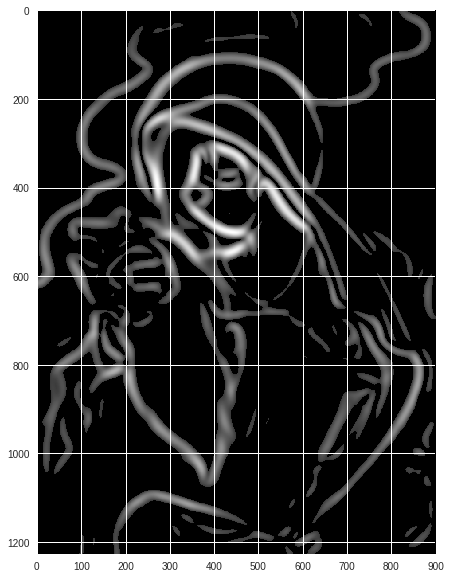

In [9]:
smooth_grad_thresh = smooth_grad_mag.copy()
smooth_grad_thresh[smooth_grad_thresh < 1.2] = 0

fig = plt.figure(figsize=(10,10))
axs = fig.add_subplot(111)

axs.imshow(smooth_grad_thresh, cmap='gray')
plt.show()

#### Enhance contrast

/home/caesarq/.virtualenvs/world/local/lib/python2.7/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float32 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


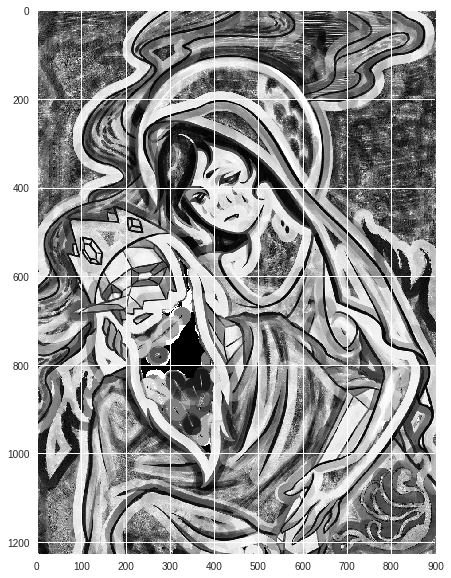

In [10]:
from skimage.filters.rank import autolevel_percentile
from skimage.filters.rank import autolevel
from skimage.morphology import disk

fig = plt.figure(figsize=(10,10))
axs = fig.add_subplot(111)

selem = disk(20)
loc_autolevel = autolevel(hsv_art[:,:,2] / 256.0, selem=selem)

axs.imshow(loc_autolevel, cmap='gray')
plt.show()



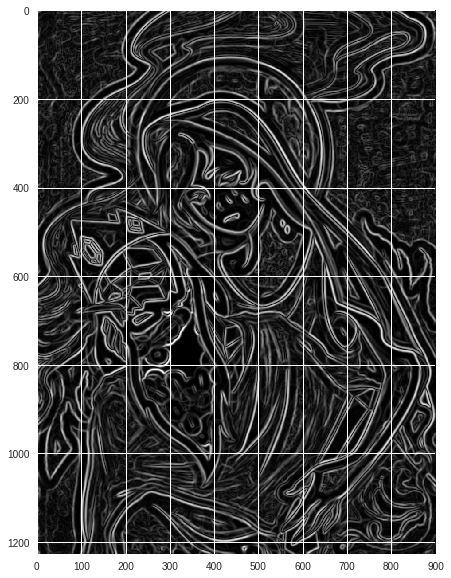

In [11]:
im_x = np.zeros(loc_autolevel.shape)
sigma = 2
ndimage.filters.gaussian_filter(loc_autolevel, (sigma,sigma), (0,1), im_x)

im_y = np.zeros(loc_autolevel.shape)
ndimage.filters.gaussian_filter(loc_autolevel, (sigma,sigma), (1,0), im_y)
plt.show()

fig = plt.figure(figsize=(10,10))
axs = fig.add_subplot(111)
sharp_grad_mag = np.sqrt(im_y**2 + im_x**2)
axs.imshow(sharp_grad_mag, cmap = 'gray')

plt.show()


#### Edge distribution

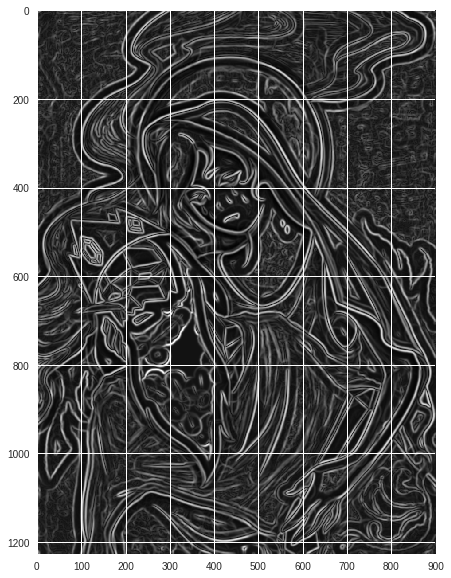

In [12]:
fig = plt.figure(figsize=(10,10))
axs = fig.add_subplot(111)

axs.imshow(sharp_grad_mag - smooth_grad_mag, cmap='gray')
plt.show()

Ps = (sharp_grad_mag - smooth_grad_mag)
#Ps /= np.sum(Ps)
#xs = np.arange(Ps.shape[0])



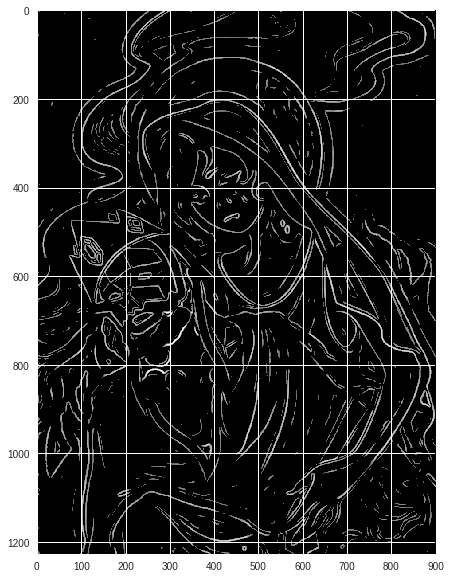

In [13]:
Ps_thresh = Ps.copy()
Ps_thresh[Ps_thresh < 20] = 0

fig = plt.figure(figsize=(10,10))
axs = fig.add_subplot(111)

axs.imshow(Ps_thresh, cmap='gray')
plt.show()

In [14]:
x_range = np.arange(sharp_grad_mag.shape[1])
y_range = np.arange(sharp_grad_mag.shape[0])
xi, yi = np.meshgrid(x_range,y_range)
inds = np.array([xi.ravel(), yi.ravel()]).T

### Getting edgier

In [15]:
from skimage import feature

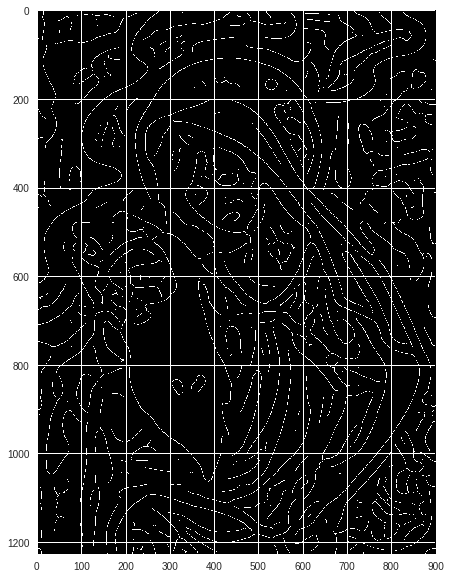

In [16]:
fig = plt.figure(figsize=(10,10))
axs = fig.add_subplot(111)
edges = feature.canny(im_smooth, sigma=1)
axs.imshow(edges, cmap = 'gray')

plt.show()

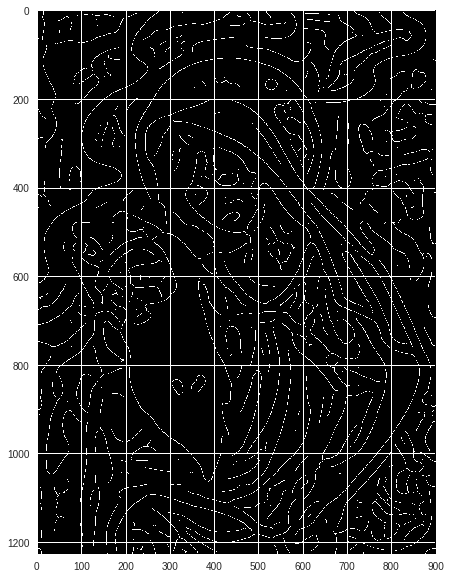

In [17]:
fig = plt.figure(figsize=(10,10))
axs = fig.add_subplot(111)
edges2 = feature.canny(loc_autolevel, sigma=5)
axs.imshow(edges, cmap = 'gray')

plt.show()

/home/caesarq/.virtualenvs/world/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  app.launch_new_instance()
/home/caesarq/.virtualenvs/world/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


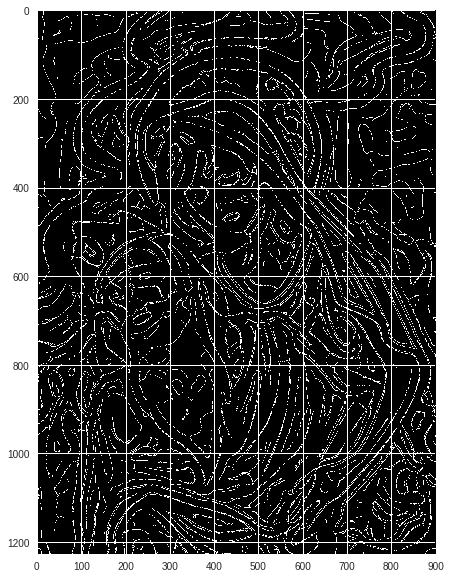

In [18]:
fig = plt.figure(figsize=(10,10))
axs = fig.add_subplot(111)
axs.imshow(edges2 - edges, cmap = 'gray')
p_edges = edges2 - edges

plt.show()

### With voronoi

In [19]:
def unique_rows(a):
    a = np.ascontiguousarray(a)
    unique_a = np.unique(a.view([('', a.dtype)]*a.shape[1]))
    return unique_a.view(a.dtype).reshape((unique_a.shape[0], a.shape[1]))

In [20]:
def genRandomBorderPoints(max_n, min_dist, rng):
    candids = np.arange(min_dist, max_n - min_dist)
    border = [0, max_n]
    
    while True:
        try:
            ind = rng.choice(candids)
        except ValueError:
            border = np.asarray(border)
            border = np.sort(border)
            return border
        
        border.append(ind)
        candids = candids[np.logical_or(candids < ind - min_dist,
                                        candids > ind + min_dist)]

    

In [31]:
help(plt.imshow)

Help on function imshow in module matplotlib.pyplot:

imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, shape=None, filternorm=1, filterrad=4.0, imlim=None, resample=None, url=None, hold=None, data=None, **kwargs)
    Display an image on the axes.
    
    Parameters
    ----------
    X : array_like, shape (n, m) or (n, m, 3) or (n, m, 4)
        Display the image in `X` to current axes.  `X` may be an
        array or a PIL image. If `X` is an array, it
        can have the following shapes and types:
    
        - MxN -- values to be mapped (float or int)
        - MxNx3 -- RGB (float or uint8)
        - MxNx4 -- RGBA (float or uint8)
    
        The value for each component of MxNx3 and MxNx4 float arrays
        should be in the range 0.0 to 1.0. MxN arrays are mapped
        to colors based on the `norm` (mapping scalar to scalar)
        and the `cmap` (mapping the normed scalar to a color).
    
    cm

(535, 2)


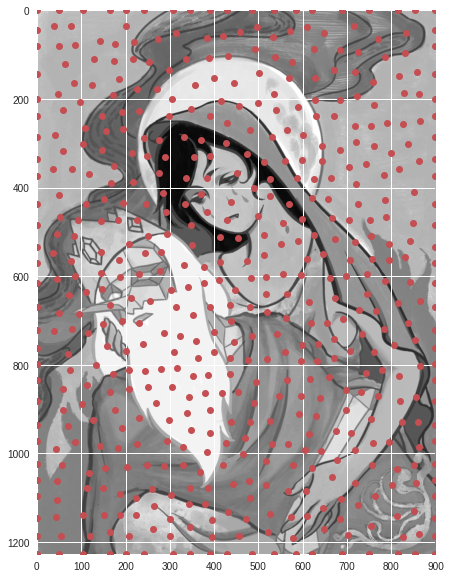

In [69]:
x_range = np.arange(sharp_grad_mag.shape[0])
y_range = np.arange(sharp_grad_mag.shape[1])
xi, yi = np.meshgrid(x_range,y_range)
inds = np.array([xi.ravel(), yi.ravel()]).T

edge_points = np.nonzero(p_edges.flatten())[0]
edge_points = np.asarray([inds[pt] for pt in edge_points]).tolist()
values = np.asarray([loc_autolevel[p[0],p[1]] for p in edge_points])
index = np.argsort(values)

min_dist = 35
# # select the best points taking min_distance into account
filtered_coords = nonMaximalSuppression(index, edge_points, 
                                        loc_autolevel.shape, min_dist).tolist()

rng = np.random.RandomState(223245)
x_range = genRandomBorderPoints(sharp_grad_mag.shape[0] - 1, min_dist, rng)
y_range = genRandomBorderPoints(sharp_grad_mag.shape[1] - 1, min_dist, rng)

lft_row = [[0, yi] for yi in y_range]
filtered_coords.extend(lft_row)

rht_row = [[x_range[-1], yi] for yi in y_range]
filtered_coords.extend(rht_row)

top_row = [[xi, 0] for xi in x_range]
filtered_coords.extend(top_row)

bot_row = [[xi, y_range[-1]] for xi in x_range]
filtered_coords.extend(bot_row)

points = np.array(filtered_coords)
points = unique_rows(points)
points = points[:,::-1]
print points.shape

fig = plt.figure(figsize=(10,10))
axs = fig.add_subplot(111)
axs.imshow(hsv_art[:,:,2], cmap = 'gray', interpolation='bilinear')
axs.plot(points[:,0], points[:,1], 'ro')


plt.show()

### Points to voronoi

#### Mosaic pattern

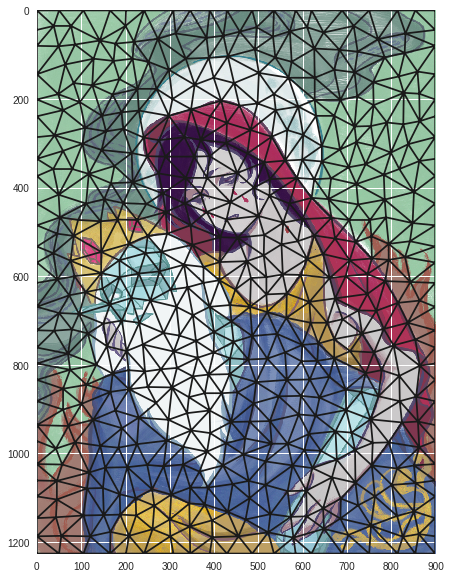

In [70]:
tri = Delaunay(points)

fig = plt.figure(figsize=(10,10))
axs = fig.add_subplot(111)
axs.imshow(art)
axs.triplot(points[:,0], points[:,1], tri.simplices.copy(), 'k-')


plt.show()


In [57]:
from tqdm import tqdm_notebook

In [58]:
def path2chunk(path, inds):
    contains = np.array([path.contains_point(ind) for ind in inds])
    keep = inds[np.where(contains)]
    return keep

In [59]:
np.max(points, axis=0)

array([ 899, 1226])

In [60]:
x_range = np.arange(sharp_grad_mag.shape[1])
y_range = np.arange(sharp_grad_mag.shape[0])
xi, yi = np.meshgrid(x_range,y_range)
all_inds = np.array([xi.ravel(), yi.ravel()]).T
anti_inds = {tuple(row) : i for i, row in enumerate(all_inds)}

In [61]:
def imageChunk(image, keep):
    imm_chunk = np.zeros(image.shape)
    kx = keep[:,0]
    ky = keep[:,1]
    imm_chunk[ky,kx,:] = image[ky,kx,:]
    return imm_chunk

In [62]:
new_image = np.zeros(art.shape)

#for region in tqdm_notebook(vor.filtered_regions, desc='regions'):
chunks = []
for region in tqdm_notebook(tri.simplices, desc='regions'):
    #vertices = vor.vertices[region + [region[0]], :] #for voronoi
    vertices = points[region] #for delaunay
    
    #Find search box
    min_x, min_y = np.min(vertices, axis=0).astype(int)
    min_ind = anti_inds[(min_x, min_y)]
    max_x, max_y = np.max(vertices, axis=0).astype(int)
    max_ind = anti_inds[(max_x, max_y)]
    reg_inds = [all_inds[i] for i in range(min_ind, max_ind)]
    reg_inds = np.asarray(reg_inds)
    
    #cntd = centroid_region(vertices).astype(int)
    #membership tests
    bbPath = mplPath.Path(vertices)
    keep = path2chunk(bbPath, reg_inds)
    
    #average colour values
    kx = keep[:,0]
    ky = keep[:,1]
    #chunks.append(imageChunk(art, keep))
    vals = np.mean(art[ky,kx,:], axis=0)
    #vals = art[cntd[0][1], cntd[0][0], :]
    new_image[ky,kx,:] = 256 - vals.astype(int)
        



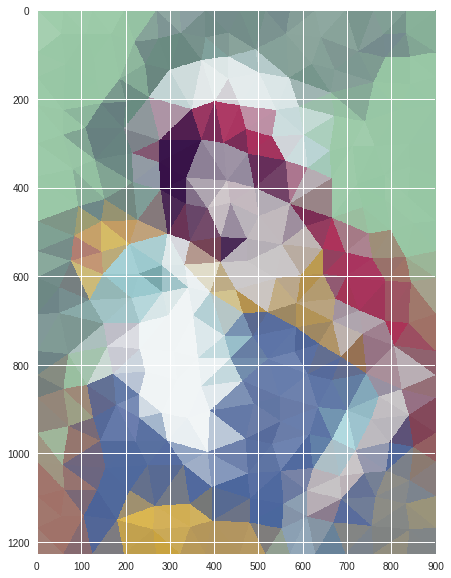

In [63]:
fig = plt.figure(figsize=(10,10))
axs = fig.add_subplot(111)
axs.imshow(new_image, interpolation='nearest')

plt.show()

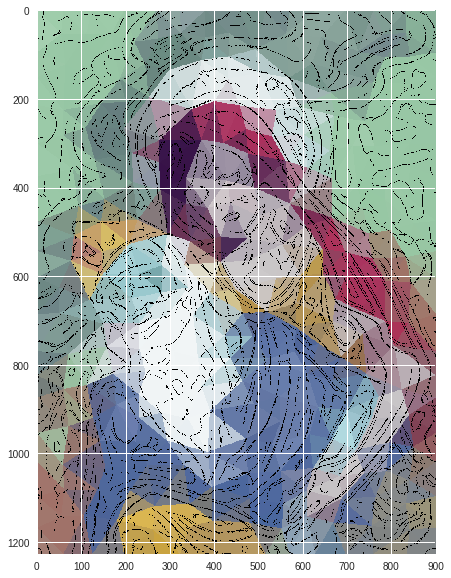

In [64]:
fig = plt.figure(figsize=(10,10))
axs = fig.add_subplot(111)
#axs.imshow(new_image[:,:,0], cmap=plt.cm.gist_heat)
#axs.imshow(new_image[:,:,2], cmap='gray')
#axs.imshow(256 - new_image)
#axs.imshow(fill_art, alpha=0.2)
windowed_art = new_image
windowed_art[p_edges] = 0
axs.imshow(windowed_art)
#axs.imshow(new_image)

plt.show()

(254491, 2)
(108942, 2)


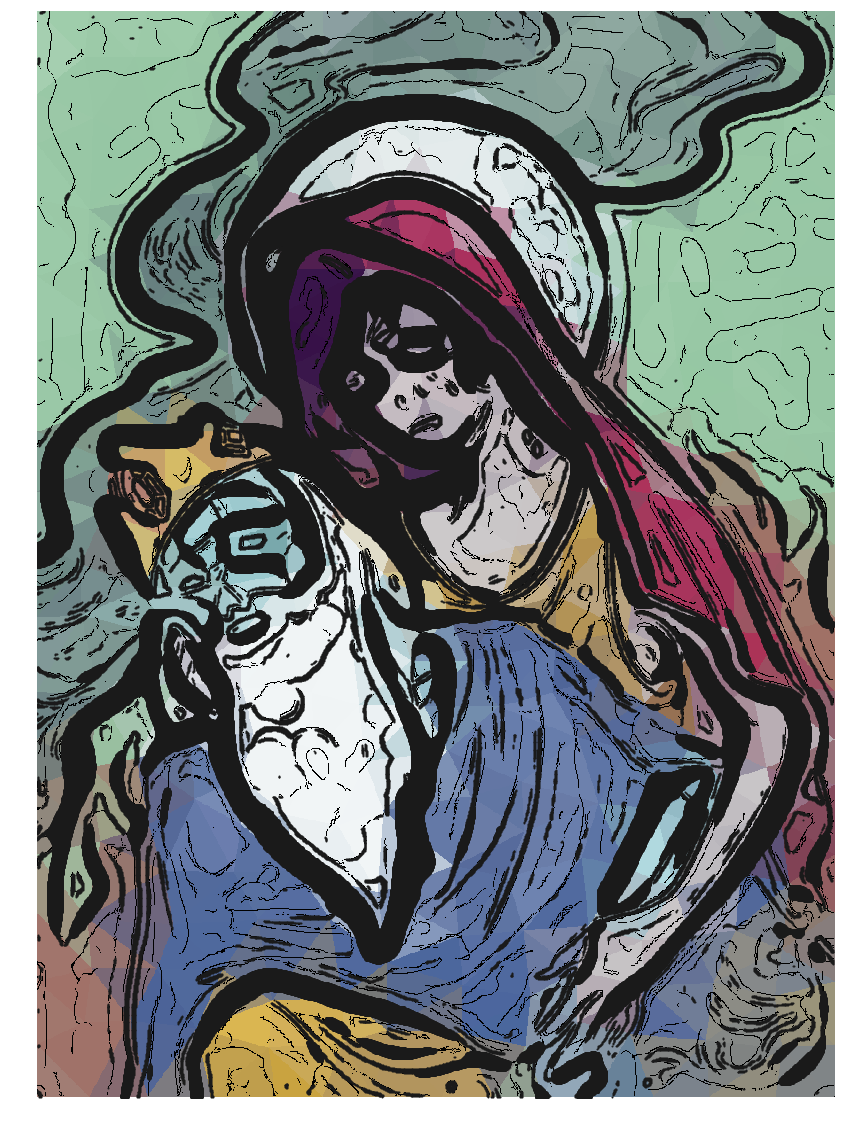

In [67]:
fig = plt.figure(figsize=(20,20))
axs = fig.add_subplot(111)
#axs.imshow(new_image[:,:,0], cmap=plt.cm.gist_heat)
#axs.imshow(new_image[:,:,2], cmap='gray')
#axs.imshow(256 - new_image)
#axs.imshow(fill_art, alpha=0.2)

axs.imshow(art, alpha=0.2)
axs.imshow(new_image)
cast_edge_points = np.nonzero(smooth_grad_thresh.flatten())[0]
cast_edge_points = all_inds[cast_edge_points]
print cast_edge_points.shape
axs.plot(cast_edge_points[:,0], cast_edge_points[:,1], 'ko', ms=3)

cast_edge_points = np.nonzero(Ps_thresh.flatten())[0]
cast_edge_points = all_inds[cast_edge_points]
print cast_edge_points.shape
axs.plot(cast_edge_points[:,0], cast_edge_points[:,1], 'ko', ms=2)

axs.set_xlim((0, new_image.shape[1]))
axs.set_ylim((new_image.shape[0],0))

plt.axis('off')
#plt.savefig("marceline_pieta.png", bbox_inches='tight', pad_inches=0)
plt.show()